In [1]:
# import funcitons to perform KMeans clustering
from sklearn.cluster import KMeans
import rioxarray as rio
import matplotlib.pyplot as plt
import numpy as np
import pickle
from yellowbrick.cluster import KElbowVisualizer

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35003,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.53 GiB
Comm: tcp://127.0.0.1:34577,Total threads: 3
Dashboard: http://127.0.0.1:39285/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:43405,


In [3]:
# functions to be used 

def xarray_to_2D(data):
    '''
    Function to convert xarray to 2D array
    '''
    data = data.stack(z=('y','x'))
    data = data.transpose('z', 'band')
    data.values = np.nan_to_num(data.values)
    return data

def pred_to_xarray(model, data, output_bands=1):
    '''
    Function to convert the prediction array to a xarray
    '''
    # transform the encoded data to a 3D array
    # template with the xarray shape
    template = data[:, 1]
    template
    # assign the encoded data to the template
    output_array = template.copy(data=model)
    # unstack xarray to get the original shape
    return output_array.unstack()

def test_cluster(X_pca):
    '''function to test KMeans clustering with different number of clusters'''
    # Instantiate the clustering model and visualizer
    print('Processing clusters...')
    model = KMeans(random_state=42)
    elb_visualizer = KElbowVisualizer(model, k=(2,11), metric='calinski_harabasz')
    elb_visualizer.fit(X_pca)
    elb_visualizer.show()
    return elb_visualizer

def predict_cluster(data_na, data, n_clusters):
    '''
    function to predict KMeans clustering
    Fits model using data without NaN values
    Predicts on data with NaN values converted to zeros
    '''
    cluster_model = KMeans(n_clusters=n_clusters, random_state=42).fit(data_na)
    cluster_model = cluster_model.predict(data)
    cluster_model = cluster_model + 1 # add 1 to avoid 0 values
    return cluster_model

def mask_water(prediction):
    import geopandas as gpd
    # load the shapefile
    shp = gpd.read_file('SHP/Suisun_mask.shp')
    # get geometry
    geometry = shp.geometry
    # clip the raster. astype(float) is necessary to store NaN values
    return prediction.astype(float).rio.clip(geometry, crs=shp.crs, drop=False)

In [5]:
# load KernelPCA raster
inputData = 'KernelPCA_clip'
img = rio.open_rasterio('Rasters/'+inputData+'.tif')
#img = rio.open_rasterio('Rasters/autoencoders.tif')
img#.isel(band=0).plot()

<xarray.DataArray (band: 3, y: 2207, x: 2522)>
[16698162 values with dtype=float64]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.756e+05 5.757e+05 ... 6.008e+05 6.009e+05
  * y            (y) float64 4.233e+06 4.233e+06 ... 4.211e+06 4.211e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
# Convert the raster data to a 2D array and re-organize the data
data = xarray_to_2D(img)
# delete rows with NaN values in data
data_na = data.dropna(dim='z', how='any')

Processing clusters...


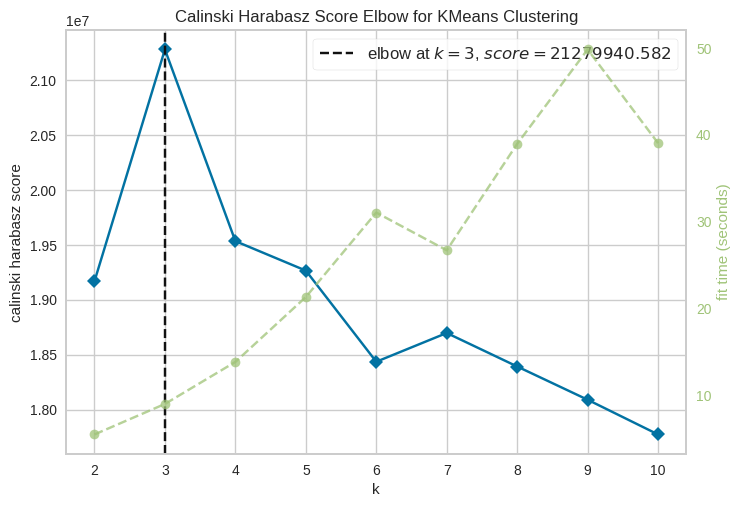

In [50]:
visualizer = test_cluster(data_na)

In [7]:
# predict best number of clusters
n_clusters=8
cluster_model = predict_cluster(data_na, data, n_clusters=n_clusters)
cluster_model

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [8]:
# prediction to xarray
prediction = pred_to_xarray(cluster_model, data, output_bands=1)
prediction

<xarray.DataArray (y: 2207, x: 2522)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)
Coordinates:
  * y            (y) float64 4.233e+06 4.233e+06 ... 4.211e+06 4.211e+06
  * x            (x) float64 5.756e+05 5.757e+05 ... 6.008e+05 6.009e+05
    band         int64 2
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [9]:
# save cluster_model to disk for later use
filename = 'cluster_model_'+inputData+'_'+str(n_clusters)+'.sav'
pickle.dump(cluster_model, open(filename, 'wb'))

In [10]:
# mask out the water
prediction_clip = mask_water(prediction)

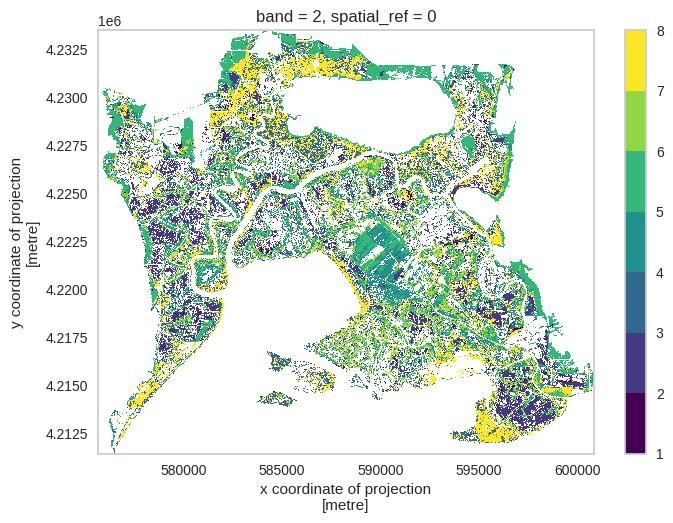

In [11]:
# plot clusters using discreate classes in labels
#col = ['#a6cee3','#1f78b4','#b2df8a']
#col = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']
prediction_clip.plot(levels=n_clusters+1)#, colors=col)
#plt.savefig('figures/cluster_map_'+inputData+'_'+str(n_clusters)+'.png', dpi=300)

In [12]:
# export TIFF
prediction_clip.rio.to_raster('Rasters/kmenas_'+inputData+'_'+str(n_clusters)+'.tif')